<a href="https://colab.research.google.com/github/yboady/Data_Science_And_ML/blob/main/Investment_Strategy_on_stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Research about stock investment
In this notebook, I aim to develop a robust investment strategy by analyzing stock market data. By leveraging data science techniques and utilizing various models, I will explore the relationships between stock prices and key financial indicators. My goal is to enhance my skills in data analysis, machine learning, and statistical modeling. Through this project, I will also gain practical experience in sourcing and processing financial data, ultimately contributing to informed investment decisions.

### Initialisation
For this project, I will use the SK-Learn libraries for machine learning and plotly for interactive graphs

In [48]:
import requests
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

### API and Dataset
I will use the free Alpha Vantage API to get dasatest on stock informations. It gives 5 informations on the daily evolution of a stock over the past 6 months :
- Open : the price of the stock at the opening of the market
- High : the highest price of the stock over the day
- Low : the lowest price of the stock over the day
- Close : the price of the stock at the closing of the market
- Volume : total number of shares traded this day

In [49]:
def getStockData(symbol, api_key):
    base_url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={api_key}&outputsize=compact"
    response = requests.get(base_url)
    data = response.json()

    if "Time Series (Daily)" not in data:
        print(f"Erreur pour le symbole {symbol}: {data.get('Note', 'Pas de données disponibles')}")
        return None

    df = pd.DataFrame(data["Time Series (Daily)"]).T
    df.columns = ["Open", "High", "Low", "Close", "Volume"]
    df = df.astype(float)
    df.index = pd.to_datetime(df.index)
    return df


### Stocks studied
I chose 3 stocks to study, Apple, Microsoft and Tesla

In [50]:
apiKey = 'IOF9S1UPN2MUQZH6'
stocks = ['AAPL', 'MSFT', 'TSLA']

stockData = {}
for stock in stocks:
    stockData[stock] = getStockData(stock, apiKey)

for stock, data in stockData.items():
    if data is not None:
        print(f"{stock} data:")
        print(data.head())

AAPL data:
              Open     High     Low   Close      Volume
2024-10-09  225.14  229.750  224.83  229.54  32165195.0
2024-10-08  224.30  225.980  223.25  225.77  31855693.0
2024-10-07  224.50  225.690  221.33  221.69  39505354.0
2024-10-04  227.90  228.000  224.13  226.80  37345098.0
2024-10-03  225.14  226.805  223.32  225.67  34044158.0
MSFT data:
              Open    High     Low   Close      Volume
2024-10-09  415.75  420.38  414.30  417.46  14858519.0
2024-10-08  410.90  415.66  408.17  414.71  19229261.0
2024-10-07  416.00  417.11  409.00  409.54  20919761.0
2024-10-04  418.24  419.75  414.97  416.06  19190913.0
2024-10-03  417.63  419.55  414.29  416.54  13686421.0
TSLA data:
              Open    High     Low   Close      Volume
2024-10-09  243.77  247.43  239.51  241.05  65843561.0
2024-10-08  243.56  246.21  240.56  244.50  56303160.0
2024-10-07  249.00  249.83  240.70  240.83  68113270.0
2024-10-04  246.69  250.96  244.58  250.08  86726285.0
2024-10-03  244.48  249.79

### Data Visualisation
First things first, I will do a plot of the 3 stocks to see their evolution in the past 6 months. For each day I chose the 'Close' value to represent the price of the stock.

In [51]:
def plot_stock_prices(stockData):
    combined_df = pd.DataFrame()

    for stock, data in stockData.items():
        data = data[['Close']].copy()
        data.rename(columns={'Close': stock}, inplace=True)
        combined_df = pd.concat([combined_df, data], axis=1)

    combined_df.reset_index(inplace=True)

    fig = px.line(combined_df, x='index', y=combined_df.columns[1:],
                  title='Stock Prices', labels={'value':'Price', 'variable':'Stock'})

    fig.update_traces(mode='lines+markers')

    fig.show()

plot_stock_prices(stockData)

### Analyse and Return
Looking at the graph, it looks like the Microsoft stock is stagnating whereas the other ones are increasing. To come up with more solid conclusions, we are going to analyse the monthly returns in compound interests of each stock to track the global trend of the stocks

In [52]:
def calculateMonthlyReturn(df):
    df['Return'] = df['Close'].shift(1) / df['Close'] - 1
    df.dropna(inplace=True)
    monthlyReturn = (df['Return'] + 1).resample('ME').prod() - 1
    return monthlyReturn

monthlyReturns = {}
for stock, data in stockData.items():
    if data is not None:
        monthlyReturns[stock] = calculateMonthlyReturn(data)

In [53]:
def plot_monthly_returns(monthly_returns):
    monthly_returns_df = pd.DataFrame(monthly_returns)
    monthly_returns_df = monthly_returns_df.reset_index().melt(id_vars='index', var_name='Stock', value_name='Return')
    monthly_returns_df.rename(columns={'index': 'Date'}, inplace=True)

    monthly_returns_df['Color'] = monthly_returns_df['Return'].apply(lambda x: 'green' if x > 0 else 'red')

    fig = px.line(monthly_returns_df, x='Date', y='Return', color='Stock', title='Rendements Mensuels des Actions')

    fig.update_traces(mode='lines+markers', marker=dict(size=8))

    fig.update_traces(marker=dict(color=monthly_returns_df['Color']), selector=dict(mode='markers'))

    numeric_columns = monthly_returns_df.select_dtypes(include=[float, int]).columns

    fig.add_shape(type="rect",
                x0=monthly_returns_df['Date'].min(), x1=monthly_returns_df['Date'].max(),
                y0=monthly_returns_df[numeric_columns].min().min(), y1=0,
                fillcolor="red", opacity=0.3, layer="below", line_width=0)

    fig.add_shape(type="rect",
                x0=monthly_returns_df['Date'].min(), x1=monthly_returns_df['Date'].max(),
                y0=0, y1=monthly_returns_df[numeric_columns].max().max(),
                fillcolor="green", opacity=0.3, layer="below", line_width=0)

    fig.show()

plot_monthly_returns(monthlyReturns)


In [54]:
def suggest_investment(monthly_returns):
    avg_returns = {}
    for stock, returns in monthly_returns.items():
        cumulative_return = (1 + returns).prod() - 1
        avg_returns[stock] = cumulative_return

    best_stock = max(avg_returns, key=avg_returns.get)
    print(f"The best stock is {best_stock} with a mean return of {avg_returns[best_stock]:.2%}")

suggest_investment(monthlyReturns)

The best stock is TSLA with a mean return of 35.83%


### Volatility and Sharp ratio
The Tesla stock seems to be the best one to invest on, but I wanna double check with a calculation of the volatility and more important, a calculation of the sharp ratio.

In [55]:
def calculateVolatilitySharpe(df, risk_free_rate=0.01):
    df['Return'] = df['Close'].shift(1) / df['Close'] - 1
    volatility = df['Return'].std() * np.sqrt(252)
    sharpeRatio = (df['Return'].mean() - risk_free_rate) / df['Return'].std()
    return volatility, sharpeRatio

for stock, data in stockData.items():
    if data is not None:
        volatility, sharpe_ratio = calculateVolatilitySharpe(data)
        print(f"{stock} - Volatilité: {volatility:.2%}, Sharpe Ratio: {sharpe_ratio:.2f}")

AAPL - Volatilité: 25.37%, Sharpe Ratio: -0.51
MSFT - Volatilité: 19.39%, Sharpe Ratio: -0.82
TSLA - Volatilité: 58.78%, Sharpe Ratio: -0.16


Finally, looking at the results, all the stocks seem to be too risky (sharp ratio > 1) to invest on, even the Tesla one.
### A new opportunity with Machine Learning ?
Maybe the monthly returns are not worth it but I'm wondering if micro trades could be better if we can predict the flow of the stock from one day to another. Now, I'm thus going to train linear regression on my dataset, trying to predict the close price of the. next day thanks to the values of the stock on the 5 past days and with the rolling mean of the stock.

Stock: AAPL

Coefficients de la régression linéaire :
Open: -0.3470
High: 0.6722
Low: 0.5002
Volume: -0.0000
MA50: -0.0007
Close-1: 0.1222
Close-2: 0.0434
Close-3: 0.0063
Close-4: 0.0513
Close-5: -0.0319
Intercept: -3.3504



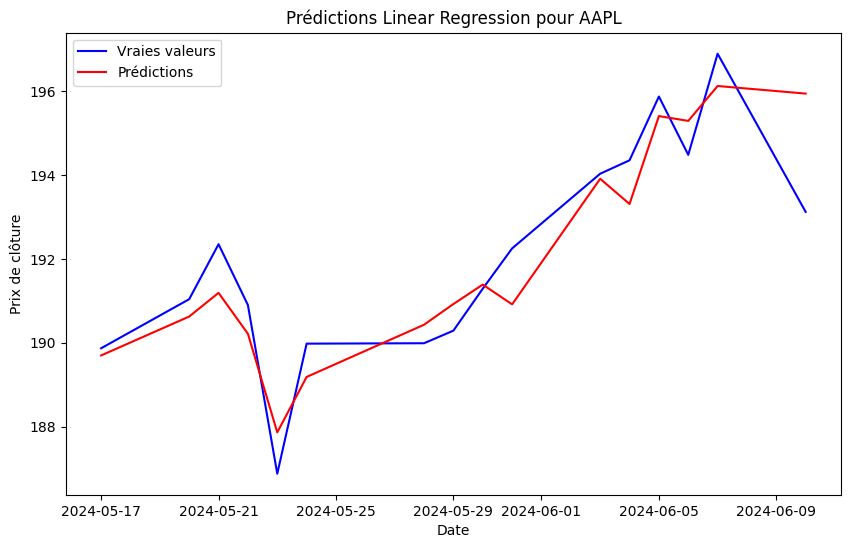

Stock: MSFT

Coefficients de la régression linéaire :
Open: -0.5426
High: 0.5865
Low: 0.8559
Volume: 0.0000
MA50: 0.0222
Close-1: 0.0944
Close-2: 0.0416
Close-3: 0.0132
Close-4: 0.0521
Close-5: -0.1115
Intercept: -4.3725



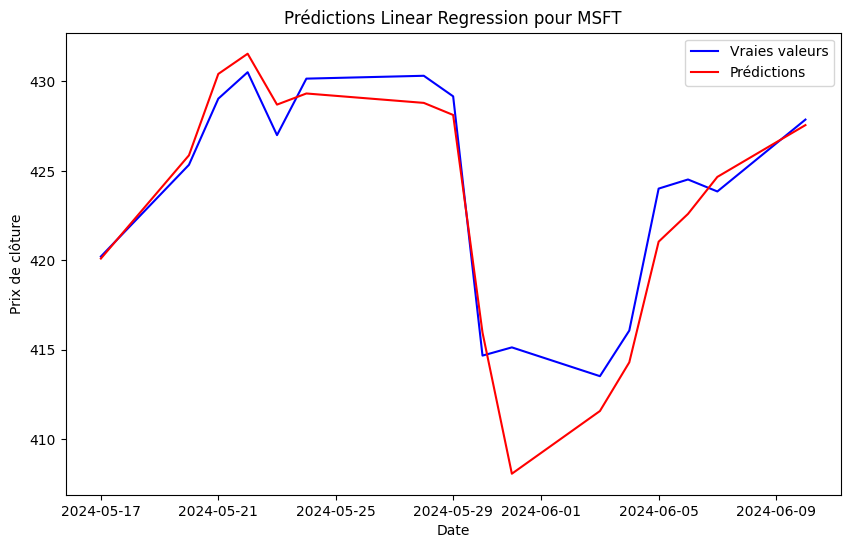

Stock: TSLA

Coefficients de la régression linéaire :
Open: -0.6810
High: 0.5431
Low: 1.0744
Volume: 0.0000
MA50: -0.0129
Close-1: 0.0630
Close-2: 0.0188
Close-3: -0.0348
Close-4: 0.0111
Close-5: 0.0114
Intercept: 3.5674



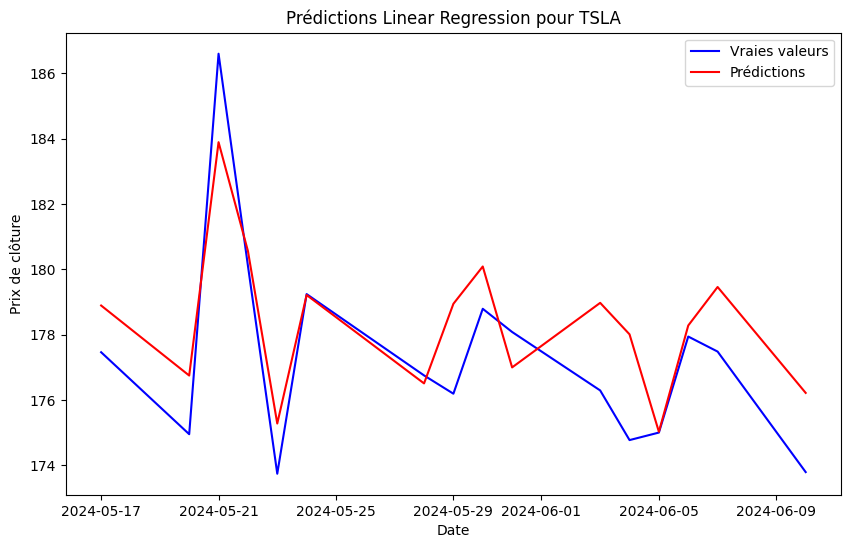

{'AAPL': {'Linear Regression': {'MSE': 1.032171945030302, 'R²': 0.8355068016150273}}, 'MSFT': {'Linear Regression': {'MSE': 5.129827909241736, 'R²': 0.8510332887739478}}, 'TSLA': {'Linear Regression': {'MSE': 3.327936373012478, 'R²': 0.6357900070626568}}}


In [56]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

def predict_stock_prices(dataframes):
    results = {}

    for stock, data in dataframes.items():
        print(f"Stock: {stock}")

        # Calcul de la moyenne mobile sur 20 jours (correction par rapport à 50 jours dans l'exemple)
        data['MA50'] = data['Close'].rolling(window=20).mean()

        # Ajout des colonnes pour les 5 derniers jours
        data['Close-1'] = data['Close'].shift(1)
        data['Close-2'] = data['Close'].shift(2)
        data['Close-3'] = data['Close'].shift(3)
        data['Close-4'] = data['Close'].shift(4)
        data['Close-5'] = data['Close'].shift(5)

        # Supprimer les valeurs manquantes après avoir décalé les données
        data.dropna(inplace=True)

        # Inclure les nouvelles colonnes dans X (les données d'entrée)
        X = data[['Open', 'High', 'Low', 'Volume', 'MA50', 'Close-1', 'Close-2', 'Close-3', 'Close-4', 'Close-5']]
        y = data['Close']

        # Découper les données par date, 80% pour l'entraînement, 20% pour le test
        split_index = int(len(X) * 0.8)
        X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
        y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

        # Définir les modèles à tester
        models = {
            'Linear Regression': LinearRegression(),
            #'SVR': SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1),
            #'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
        }

        # Stocker les résultats de chaque modèle
        model_results = {}
        for name, model in models.items():
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)

            # Calcul des performances
            mse = mean_squared_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)

            model_results[name] = {'MSE': mse, 'R²': r2}

            # Imprimer les coefficients pour le modèle de régression linéaire
            if name == 'Linear Regression':
                print("\nCoefficients de la régression linéaire :")
                coef_dict = dict(zip(X.columns, model.coef_))
                for feature, coef in coef_dict.items():
                    print(f"{feature}: {coef:.4f}")
                print(f"Intercept: {model.intercept_:.4f}\n")

            # Plot des prédictions par rapport aux vraies valeurs
            plt.figure(figsize=(10, 6))
            plt.plot(y_test.index, y_test, label="Vraies valeurs", color='blue')
            plt.plot(y_test.index, predictions, label="Prédictions", color='red')
            plt.title(f"Prédictions {name} pour {stock}")
            plt.xlabel("Date")
            plt.ylabel("Prix de clôture")
            plt.legend()
            plt.show()

        # Stocker les résultats pour chaque action
        results[stock] = model_results

    return results

# Exécuter la fonction pour prédire les prix des actions
results = predict_stock_prices(stockData)
print(results)


## Conclusion
Tesla (TSLA), on the first hand, presents an interesting paradox. Despite the stock historically offers better returns, it's the worst in this section due to its higher volatility (as seen with a lower R² and higher MSE).

On the other hand, the results suggest that engaging in micro trades on a daily basis for Apple (AAPL) and Microsoft (MSFT) could be a promising strategy. Both companies show high model performance, with relatively low MSE and strong R² values, indicating a good ability to predict their price movements based on past data. These stocks exhibit more stability and lower volatility, making them more suitable for short-term trading where precision is key.

However, it's important to recognize that real-world events—such as economic shifts, corporate earnings reports, or geopolitical developments—could heavily influence stock prices. These factors might not be captured fully by historical data alone and can introduce unexpected volatility. For this reason, a balanced approach that considers both technical predictions and external market conditions is essential for making informed trading decisions.